### Explore FP Analysis 

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Load in local csv
folder = '/root/capsule/data/filtered_data_20240911/filtered_data_20240911.csv'
df = pd.read_csv(folder)

df['session_end_time'] = pd.to_datetime(df['session_end_time'])

df['session_end_time'] = df['session_end_time'].dt.date

df.head()

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,water_after_session_last_session,location,session_name,creation_time,subject_genotype,probes,results,results_location,session_time,docDB_status
0,730942,2024-09-10,181826,14.0,447-3-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
1,741211,2024-09-10,181707,14.0,447-3-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_74...,behavior_741211_2024-09-10_18-17-07,2024-09-10T18:17:07-07:00,wt/wt,[],NaN,NaN,18-17-07,1_uploaded but not processed
2,736198,2024-09-10,181446,14.0,447-2-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_73...,behavior_736198_2024-09-10_18-14-46,2024-09-10T18:14:46-07:00,wt/wt,[],NaN,NaN,18-14-46,1_uploaded but not processed
3,730945,2024-09-10,181112,14.0,447-2-B,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
4,741213,2024-09-10,180831,14.0,447-2-A,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_74...,behavior_741213_2024-09-10_18-08-31,2024-09-10T18:08:31-07:00,wt/wt,[],NaN,NaN,18-08-31,1_uploaded but not processed


In [ ]:
# All columns in df
print(df.columns.tolist())

['subject_id', 'session_date', 'nwb_suffix', 'session', 'rig', 'user_name', 'curriculum_name', 'curriculum_version', 'current_stage_actual', 'task', 'notes', 'experiment_description', 'session_start_time', 'session_end_time', 'session_run_time_in_min', 'water_in_session_foraging', 'water_in_session_manual', 'water_in_session_total', 'water_after_session', 'water_day_total', 'base_weight', 'target_weight', 'target_weight_ratio', 'weight_after', 'laser_1_calibration_power', 'laser_2_calibration_power', 'laser_1_target_areas', 'laser_2_target_areas', 'commit_ID', 'repo_url', 'current_branch', 'weight_after_ratio', 'p_reward_sum_mean', 'p_reward_sum_std', 'p_reward_sum_median', 'p_reward_contrast_mean', 'p_reware_contrast_median', 'effective_block_length_mean', 'effective_block_length_std', 'effective_block_length_median', 'effective_block_length_min', 'effective_block_length_max', 'duration_gocue_stop_mean', 'duration_gocue_stop_std', 'duration_gocue_stop_median', 'duration_gocue_stop_min

In [ ]:
# Check NaN values

nan_count = df.isnull().sum()

max_nan = nan_count.idxmax()
max_nan_count = nan_count.max()

nan_count = nan_count[nan_count > 0]

threshold = 1000

above_threshold_nan = nan_count[nan_count > threshold]

print(f'Above threshold: {above_threshold_nan}')

Above threshold: curriculum_name              1822
curriculum_version           1822
current_stage_actual         1822
notes                        2320
experiment_description       3763
laser_1_calibration_power    3666
laser_2_calibration_power    3665
laser_1_target_areas         3651
laser_2_target_areas         3650
commit_ID                    1744
repo_url                     1744
current_branch               1744
curriculum_schema_version    1822
location                     3022
session_name                 3022
creation_time                3022
subject_genotype             3022
probes                       3022
results                      3354
results_location             3354
session_time                 3022
dtype: int64


#### Variable Correlation
____

In [ ]:
# Main df is just to keep track of what I think is interesting 
main_df = df[['subject_id', 'curriculum_name', 'current_stage_actual', 'session_end_time', 'subject_genotype','session_run_time_in_min', 'p_reward_sum_mean', 'effective_block_length_mean', 'duration_gocue_stop_mean', 'duration_delay_period_mean', 'duration_iti_mean', 'finished_rate', 'reward_rate', 'foraging_eff', 'reaction_time_mean', 'avg_trial_length_in_seconds']]

main_df = main_df.dropna().copy()

# By sub selecting these variables, decreasing the sample size significantly, will affect model

variable_corr_df = main_df[(main_df['curriculum_name'] == 'Uncoupled Baiting') & (df['current_stage_actual'] == 'GRADUATED')][['subject_id', 'session_end_time', 'foraging_eff', 'session_run_time_in_min', 'p_reward_sum_mean', 'effective_block_length_mean', 'duration_gocue_stop_mean', 'duration_delay_period_mean', 'duration_iti_mean', 'finished_rate', 'reward_rate', 'reaction_time_mean', 'avg_trial_length_in_seconds']]

print(variable_corr_df[['session_run_time_in_min', 'finished_rate', 'effective_block_length_mean', 'p_reward_sum_mean', 'duration_gocue_stop_mean', 'duration_delay_period_mean', 'duration_iti_mean', 'finished_rate', 'reward_rate', 'reaction_time_mean', 'avg_trial_length_in_seconds']].describe())


       session_run_time_in_min  finished_rate  effective_block_length_mean  \
count                42.000000      42.000000                    42.000000   
mean                 75.357143       0.907764                    17.192336   
std                  11.495113       0.127892                     2.039754   
min                  38.000000       0.369565                    14.400000   
25%                  75.000000       0.866505                    15.894725   
50%                  75.000000       0.956178                    16.727778   
75%                  80.000000       0.990341                    17.491071   
max                  90.000000       1.000000                    22.363636   

       p_reward_sum_mean  duration_gocue_stop_mean  \
count          42.000000                 42.000000   
mean            0.815652                  3.299493   
std             0.047963                  0.132477   
min             0.678672                  3.159613   
25%             0.778544   

/tmp/ipykernel_17697/1426339165.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
variable_corr_df.head()

,subject_id,session_end_time,foraging_eff,session_run_time_in_min,p_reward_sum_mean,effective_block_length_mean,duration_gocue_stop_mean,duration_delay_period_mean,duration_iti_mean,finished_rate,reward_rate,reaction_time_mean,avg_trial_length_in_seconds
1,741211,2024-09-10,0.768945,75,0.853073,16.500000,3.190522,1.242515,3.880825,0.988827,0.517891,0.171070,8.379888
2,736198,2024-09-10,0.708424,75,0.808876,15.333333,3.346972,1.518895,3.937447,0.988166,0.459082,0.328705,8.875740
4,741213,2024-09-10,0.740106,75,0.755513,17.333333,3.219867,1.104705,4.171514,0.998099,0.459048,0.208005,8.555133
22,741211,2024-09-09,0.707968,75,0.810654,17.166667,3.159613,1.255320,3.929457,1.000000,0.459813,0.149519,8.411215
25,736198,2024-09-09,0.778647,75,0.854274,15.612903,3.447830,1.515321,3.915232,0.946322,0.518908,0.405383,8.946322


In [ ]:
# Data preprocessing 

# Separate features and foraging efficiency 

X = variable_corr_df.drop(['foraging_eff', 'subject_id', 'session_end_time'], axis=1)
y = variable_corr_df['foraging_eff']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index) # create new scaled dataframe 

X_scaled.head()

,session_run_time_in_min,p_reward_sum_mean,effective_block_length_mean,duration_gocue_stop_mean,duration_delay_period_mean,duration_iti_mean,finished_rate,reward_rate,reaction_time_mean,avg_trial_length_in_seconds
1,-0.031446,0.789648,-0.343535,-0.832532,-0.857630,-1.175935,0.641520,0.296019,-0.726693,-1.309525
2,-0.031446,-0.142993,-0.922433,0.362738,0.231494,-0.719613,0.636288,-0.625929,1.594643,0.044661
4,-0.031446,-1.269046,0.069963,-0.608337,-1.400698,1.166788,0.714898,-0.626466,-0.182778,-0.830926
22,-0.031446,-0.105464,-0.012737,-1.068677,-0.807173,-0.784002,0.729944,-0.614466,-1.044054,-1.223971
25,-0.031446,0.815007,-0.783711,1.133293,0.217408,-0.898644,0.305142,0.311959,2.723803,0.237424


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_train_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:           foraging_eff   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     390.0
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           2.32e-22
Time:                        16:04:07   Log-Likelihood:                 118.34
No. Observations:                  33   AIC:                            -214.7
Df Residuals:                      22   BIC:                            -198.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

Coefficients: 
 const                          0.757400
session_run_time_in_min        0.002810
p_reward_sum_mean             -0.030823
effective_block_length_mean   -0.003479
duration_gocue_stop_mean      -0.042472
duration_delay_period_mean    -0.000336
duration_iti_mean             -0.000817
finished_rate                 -0.029610
reward_rate                    0.094050
reaction_time_mean             0.021041
avg_trial_length_in_seconds   -0.002264
dtype: float64


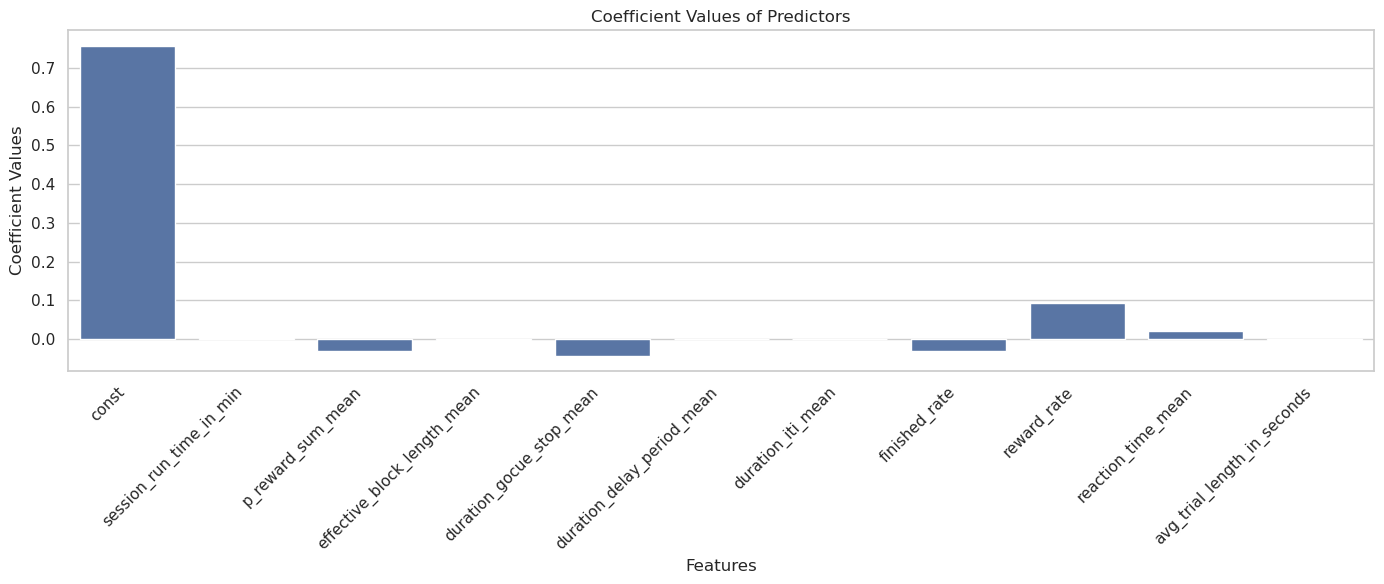

In [ ]:
coeffs = ols_model.params
print(f"Coefficients: \n {coeffs}")

coeff_df = pd.DataFrame({'column': coeffs.index, 'coeffs': coeffs.values})

sns.set_theme()
sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))
sns.barplot(x='column', y='coeffs', data=coeff_df)

plt.title('Coefficient Values of Predictors')
plt.xlabel('Features')
plt.ylabel('Coefficient Values')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

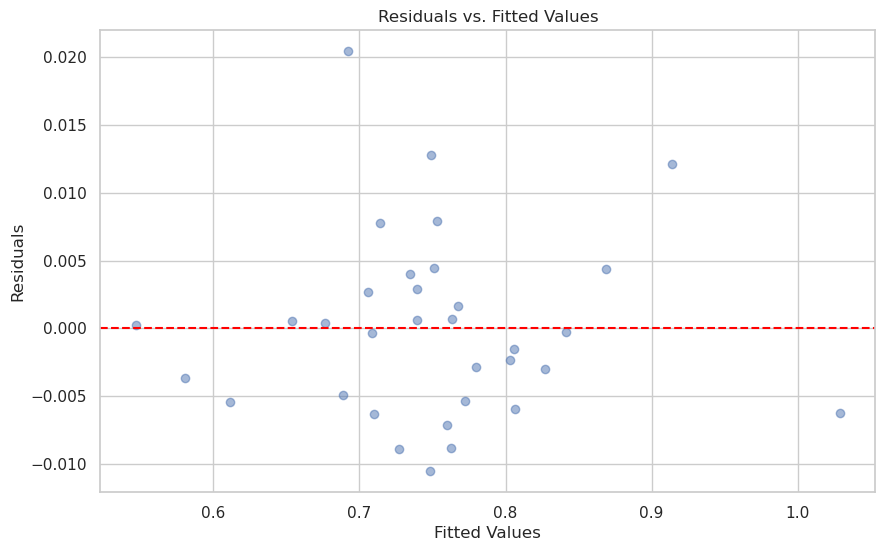

In [ ]:
# Plot residuals 

residuals = ols_model.resid
fitted_values = ols_model.fittedvalues

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Adds a horizontal line at zero
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#### Comparing stages to averaged foraging efficiency
____

In [ ]:
# Check dimensions and content of dataframe for variables of interest: 

# Find all instances of unique subject ids
ids = df['subject_id'].unique()
print(f'number of unique ids: {len(ids)}')

# Find total stage count
num_stage = df['current_stage_actual'].unique()
stages = df['current_stage_actual']

# Find total foraging efficiency value count 
forag_eff_count = df['foraging_eff']

# Find total dates assigned per foraging efficiency score 
session_end_times_count = df['session_end_time'].unique()

print(f'types of stages: {num_stage}, number of total stages {len(stages)}')

print(f'number of assigned dates {len(session_end_times_count)}')

print(f'number of forag eff scores: {len(forag_eff_count)}')

number of unique ids: 183
types of stages: ['GRADUATED' 'STAGE_3' 'STAGE_1_WARMUP' 'STAGE_1' 'STAGE_FINAL' 'STAGE_2'
 'STAGE_4' nan], number of total stages 3763
number of assigned dates 283
number of forag eff scores: 3763


In [ ]:
# Create new foraging efficiency df
fe_df = df[['subject_id', 'current_stage_actual','session_end_time','foraging_eff']]

print(fe_df.shape)
fe_df.head()

(3763, 4)


,subject_id,current_stage_actual,session_end_time,foraging_eff
0,730942,GRADUATED,2024-09-10,0.761435
1,741211,GRADUATED,2024-09-10,0.768945
2,736198,GRADUATED,2024-09-10,0.708424
3,730945,GRADUATED,2024-09-10,0.722345
4,741213,GRADUATED,2024-09-10,0.740106


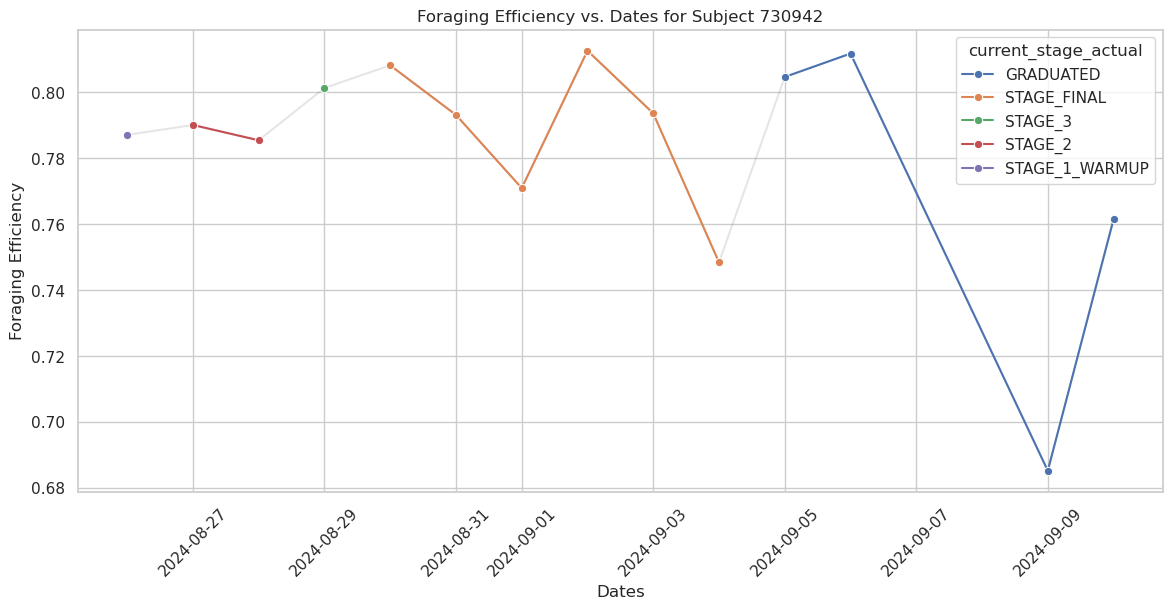

In [ ]:
# Plotting for 1 subject id over corresponding dates 

subject_id = 730942

# Filter for selected subject id and create new dataframe for only that subject id
fe_df_filtered = fe_df[fe_df['subject_id'] == subject_id]

plt.figure(figsize=(14, 6))

plt.plot(fe_df_filtered['session_end_time'], fe_df_filtered['foraging_eff'], color='grey', alpha=0.2, zorder=1)

sns.lineplot(data=fe_df_filtered, x='session_end_time', y='foraging_eff', hue='current_stage_actual', marker='o', zorder=2)

plt.xlabel('Dates')
plt.ylabel('Foraging Efficiency')
plt.title(f'Foraging Efficiency vs. Dates for Subject {subject_id}')
plt.xticks(rotation = 45)
plt.grid(True)

plt.show()

In [ ]:
# Create design matrices 

# Sort dataframe by subject id and session date 
fe_df = fe_df.sort_values(['subject_id', 'session_end_time'])

# Get unique stages and subjects
stages = fe_df['current_stage_actual'].unique()
subjects = fe_df['subject_id'].unique()

# Initialize a dictionary to store the arrays for each stage
stage_arrays = {}

for stage in stages:
    # Filter the dataframe for the current stage
    stage_df = fe_df[fe_df['current_stage_actual'] == stage]
    
    # Get the max number of sessions for this stage
    max_sessions = stage_df.groupby('subject_id').size().max()
    
    # For the NaN stage
    if pd.isna(max_sessions):
        print(f"No data found for stage {stage}")
        continue
    
    max_sessions = int(max_sessions)
    
    # Create an empty array with dimensions (subject x max sessions)
    stage_array = np.full((len(subjects), max_sessions), np.nan)
    
    # Fill the array with foraging efficiency scores
    for i, subject in enumerate(subjects):
        subject_data = stage_df[stage_df['subject_id'] == subject]['foraging_eff'].values
        stage_array[i, :len(subject_data)] = subject_data
    
    stage_arrays[stage] = stage_array

for stage, array in stage_arrays.items():
    print(f"Stage {stage}: Array shape = {array.shape}")

No data found for stage nan. Skipping.
Stage STAGE_3: Array shape = (183, 23)
Stage STAGE_FINAL: Array shape = (183, 34)
Stage STAGE_2: Array shape = (183, 14)
Stage STAGE_1: Array shape = (183, 9)
Stage GRADUATED: Array shape = (183, 22)
Stage STAGE_1_WARMUP: Array shape = (183, 2)
Stage STAGE_4: Array shape = (183, 10)


In [ ]:
def print_array_sample(array, stage, max_rows=20, max_cols=20):
    print(f"\nSample of array for {stage}:")
    rows, cols = array.shape
    sample_rows = min(rows, max_rows)
    sample_cols = min(cols, max_cols)
    
    # Print column indices
    print("     " + " ".join(f"{i:^7}" for i in range(sample_cols)))
    
    for i in range(sample_rows):
        print(f"{i:<4}", end=" ")
        for j in range(sample_cols):
            value = array[i, j]
            if pd.isna(value):
                print(f"{'NaN':^7}", end=" ")
            else:
                print(f"{value:7.2f}", end=" ")
        print()
    
    if rows > max_rows or cols > max_cols:
        print("... (truncated)")

# Print summary and sample of the created arrays
for stage, array in stage_arrays.items():
    print(f"\nStage {stage}:")
    print(f"Array shape = {array.shape}")
    print(f"Number of non-NaN values: {np.count_nonzero(~np.isnan(array))}")
    print(f"Percentage of non-NaN values: {(np.count_nonzero(~np.isnan(array)) / array.size) * 100:.2f}%")
    print_array_sample(array, stage)


Stage STAGE_3:
Array shape = (183, 23)
Number of non-NaN values: 343
Percentage of non-NaN values: 8.15%

Sample of array for STAGE_3:
        0       1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19   
0      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4      NaN     NaN     NaN     NaN 

In [ ]:
def plot_array_heatmap(array, stage):
    plt.figure(figsize=(10,8))
    plt.imshow(array, cmap='viridis', aspect='auto')
    plt.colorbar(label='Foraging Efficiency')
    plt.title(f'Foraging Efficiency Heatmap for {stage}')
    plt.xlabel('Session Index')
    plt.ylabel('Subject Index')
    plt.show()

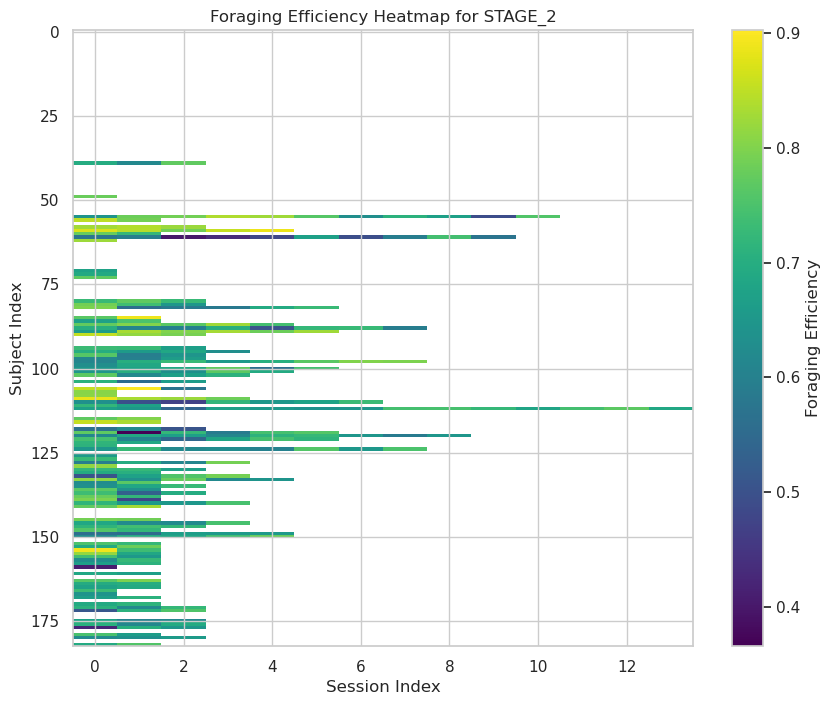

In [ ]:
# Plot heatmap to see distribution
plot_array_heatmap(stage_arrays['STAGE_2'], 'STAGE_2')

In [ ]:
stage_averages = {}

for stage, array in stage_arrays.items():
    # Calculate the mean along axis 0 (across subjects)
    # nan_mean ignores NaN values in the calculation
    stage_average = np.nanmean(array, axis=0)
    stage_averages[stage] = stage_average

# Print the average vectors
for stage, average_vector in stage_averages.items():
    print(f"\nAverage foraging efficiency for {stage}:")
    print(average_vector)
    print(f"Shape: {average_vector.shape}")



Average foraging efficiency for STAGE_3:
[0.70500029 0.69082493 0.67177972 0.68738731 0.69273701 0.70384535
 0.6984189  0.67614156 0.67829725 0.66194108 0.7400141  0.66462809
 0.71670851 0.58801336 0.81947407 0.74785129 0.74269591 0.64629727
 0.78836737 0.78749107 0.75398903 0.65941407 0.70178278]
Shape: (23,)

Average foraging efficiency for STAGE_FINAL:
[0.74788405 0.72549572 0.73488584 0.72458844 0.74734226 0.72547093
 0.75402175 0.74591938 0.75086793 0.76743316 0.77863787 0.76894273
 0.75000086 0.68943539 0.75932886 0.72865993 0.69040554 0.74062562
 0.78536215 0.74329419 0.72109591 0.76363911 0.77754268 0.82990276
 0.68144492 0.63867164 0.74569509 0.70253384 0.73084934 0.65001114
 0.64167557 0.66923119 0.74626513 0.94017255]
Shape: (34,)

Average foraging efficiency for STAGE_2:
[0.71032023 0.69378303 0.67382871 0.70658589 0.68701067 0.72975525
 0.66593359 0.68227845 0.70222827 0.59594926 0.71824228 0.74139031
 0.7666472  0.68765281]
Shape: (14,)

Average foraging efficiency for S

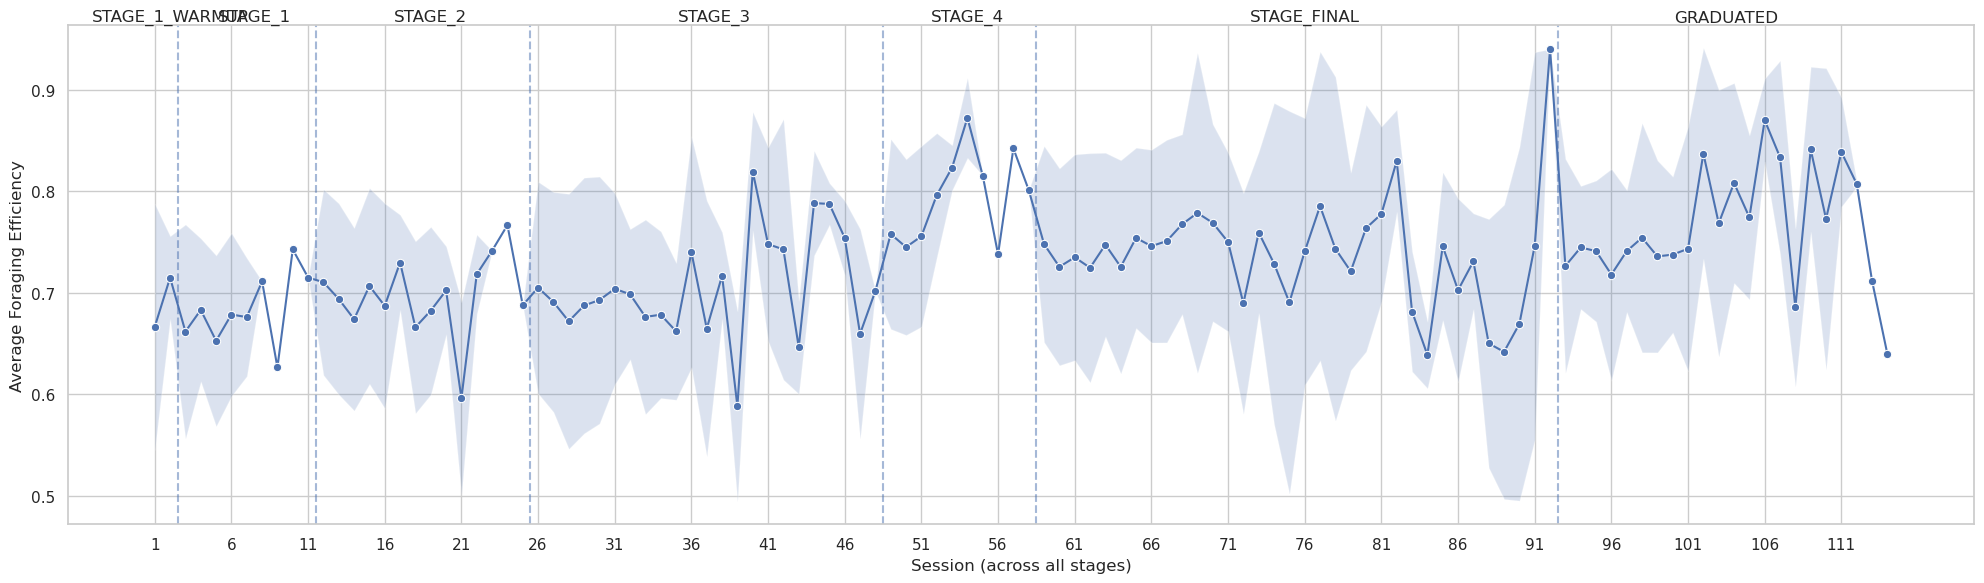

In [ ]:
stage_sequence = ['STAGE_1_WARMUP', 'STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_4', 'STAGE_FINAL', 'GRADUATED']

# Prepare data for plotting
data = []
overall_session = 0

for stage in stage_sequence:
    if stage in stage_arrays:
        stage_data = stage_arrays[stage]
        num_sessions = stage_data.shape[1]
        
        for session in range(num_sessions):
            session_data = stage_data[:, session]
            mean = np.nanmean(session_data)
            std = np.nanstd(session_data)
            
            data.append({
                'Stage': stage,
                'Session': overall_session + 1,
                'Mean': mean,
                'Std': std
            })
            
            overall_session += 1
    else:
        print(f" {stage} not found in the data.")

# Create plotting dataframe 
stage_plot_df = pd.DataFrame(data)


plt.figure(figsize=(20, 6))
sns.set_style("whitegrid")

# Plotting Function
sns.lineplot(x='Session', y='Mean', data=stage_plot_df, marker='o')


plt.fill_between(stage_plot_df['Session'], stage_plot_df['Mean'] - stage_plot_df['Std'], stage_plot_df['Mean'] + stage_plot_df['Std'], alpha=0.2)


plt.xlabel('Session (across all stages)', fontsize=12)
plt.ylabel('Average Foraging Efficiency', fontsize=12)

stage_boundaries = [stage_plot_df[stage_plot_df['Stage'] == stage]['Session'].min() for stage in stage_sequence[1:]]
for boundary in stage_boundaries:
    plt.axvline(x=boundary - 0.5, color='b', linestyle='--', alpha=0.5)

for i, stage in enumerate(stage_sequence):
    if i == 0:
        start = stage_plot_df['Session'].min()
    else:
        start = stage_boundaries[i-1]
    
    if i == len(stage_sequence) - 1:
        end = stage_plot_df['Session'].max()
    else:
        end = stage_boundaries[i]
    
    mid_point = (start + end) / 2
    plt.text(mid_point, plt.ylim()[1], stage, 
             horizontalalignment='center', verticalalignment='bottom')

plt.xticks(range(1, stage_plot_df['Session'].max() + 1, 5))

plt.tight_layout()
plt.show()

#### Comparing genotypes to averaged foraging efficiency

In [ ]:
geno_df = df[['subject_id', 'subject_genotype', 'session_end_time','foraging_eff']]

geno_df = geno_df.sort_values(['subject_genotype', 'session_end_time'])

geno_df.head()

,subject_id,subject_genotype,session_end_time,foraging_eff
1348,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-10,0.714286
1321,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-11,0.705846
1298,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-12,0.505319
1212,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-20,0.779528
1187,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-21,0.673098


In [ ]:
# Find all instances of unique subject ids
ids = geno_df['subject_id'].unique()
print(f'number of unique ids: {len(ids)}')

# Find total stage count
num_geno = geno_df['subject_genotype'].unique()
genos = geno_df['subject_genotype']

# Find total foraging efficiency value count 
forag_eff_count = geno_df['foraging_eff']

# Find total dates assigned per foraging efficiency score 
session_end_times_count = geno_df['session_end_time'].unique()

print(f'types of genotypes: {num_geno}, number of total genotypes {len(genos)}')

print(f'number of assigned dates {len(session_end_times_count)}')

print(f'number of forag eff scores: {len(forag_eff_count)}')

number of unique ids: 183
types of genotypes: ['Ai148(TIT2L-GC6f-ICL-tTA2)/wt' 'Dbh-Cre-KI/wt'
 'Dbh-Cre-KI/wt;Oi2(TIT2L-jGCaMP8s-WPRE-ICL-IRES-tTA2-WPRE)/wt'
 'Fos2A-iCreER/wt;Ai75(RCL-nT)/wt' 'Gad2-IRES-Cre/Gad2-IRES-Cre'
 'Oi8(H11-CAG-Cas9)/Oi8(H11-CAG-Cas9)' 'Pdyn-IRES-Cre/Pdyn-IRES-Cre'
 'Sert-Cre/wt' 'Slc17a8-iCre/wt;Ai14(RCL-tdT)/wt' 'Slc32a1-IRES-Cre/wt'
 'Slc6a3-IRES-Cre_Bkmn/wt' 'VGAT-ChR2-YFP/wt' 'wt/wt' nan], number of total genotypes 3763
number of assigned dates 283
number of forag eff scores: 3763


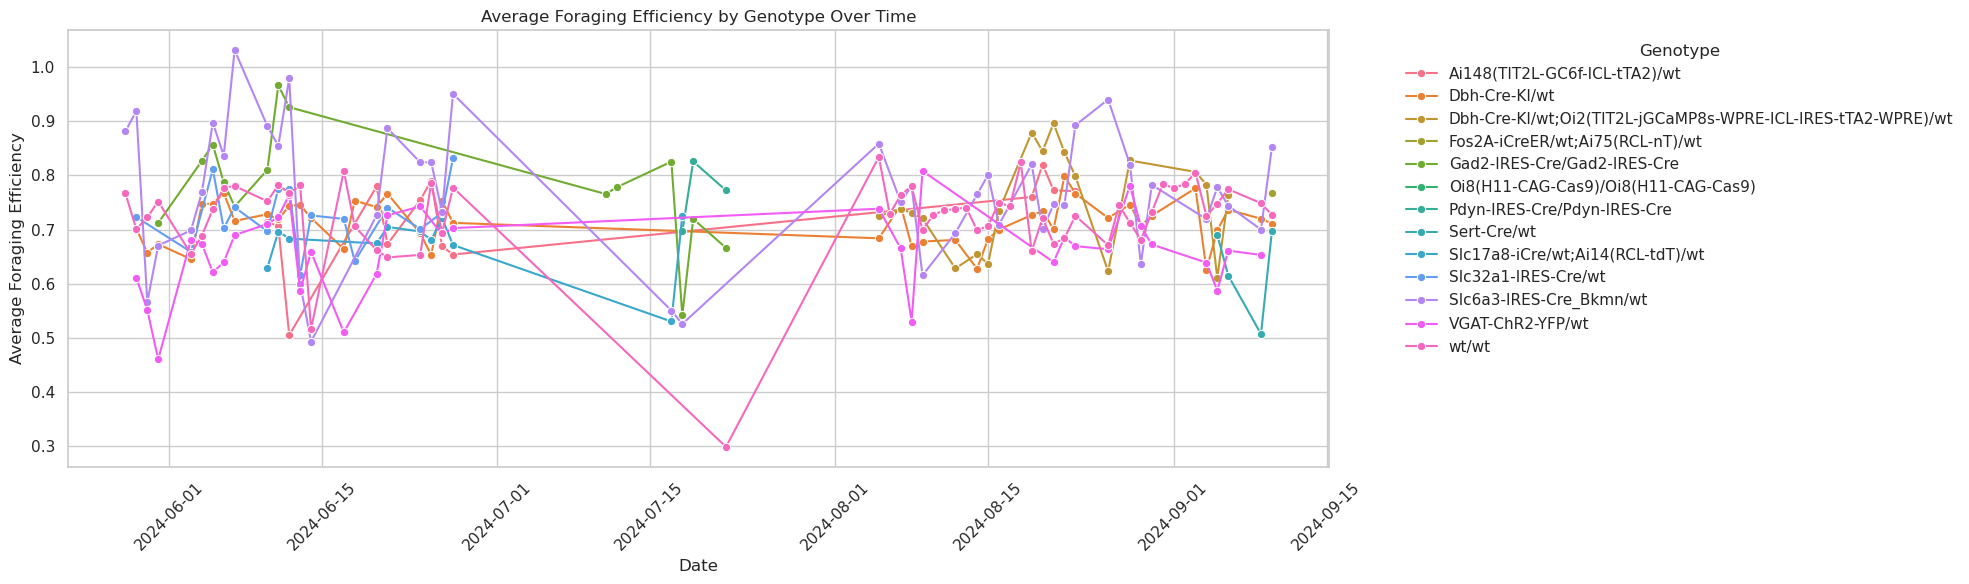

                                                    count      mean       std  \
subject_genotype                                                                
Ai148(TIT2L-GC6f-ICL-tTA2)/wt                        13.0  0.720680  0.082681   
Dbh-Cre-KI/wt                                        44.0  0.713916  0.040147   
Dbh-Cre-KI/wt;Oi2(TIT2L-jGCaMP8s-WPRE-ICL-IRES-...   19.0  0.749528  0.089062   
Fos2A-iCreER/wt;Ai75(RCL-nT)/wt                       1.0  0.768072       NaN   
Gad2-IRES-Cre/Gad2-IRES-Cre                          14.0  0.780276  0.106144   
Oi8(H11-CAG-Cas9)/Oi8(H11-CAG-Cas9)                   1.0  0.728871       NaN   
Pdyn-IRES-Cre/Pdyn-IRES-Cre                           3.0  0.764816  0.064837   
Sert-Cre/wt                                           4.0  0.627429  0.088281   
Slc17a8-iCre/wt;Ai14(RCL-tdT)/wt                     11.0  0.673968  0.054327   
Slc32a1-IRES-Cre/wt                                  16.0  0.724327  0.057402   
Slc6a3-IRES-Cre_Bkmn/wt     

In [ ]:
# plot average foraging efficiency over time

# Sort the dataframe by date
geno_df = geno_df.sort_values('session_end_time')


# Group by genotype, date, and calculate mean foraging efficiency 
grouped_df = geno_df.groupby(['subject_genotype', 'session_end_time'])['foraging_eff'].mean().reset_index()


# Plot grouped dataframe 
plt.figure(figsize=(20, 6))

sns.lineplot(data=grouped_df, x='session_end_time', y='foraging_eff', hue='subject_genotype', marker='o')

plt.xlabel('Date')
plt.ylabel('Average Foraging Efficiency')
plt.title('Average Foraging Efficiency by Genotype Over Time')
plt.xticks(rotation=45)
plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='best', frameon=False)

plt.tight_layout()
plt.show()

print(grouped_df.groupby('subject_genotype')['foraging_eff'].describe())

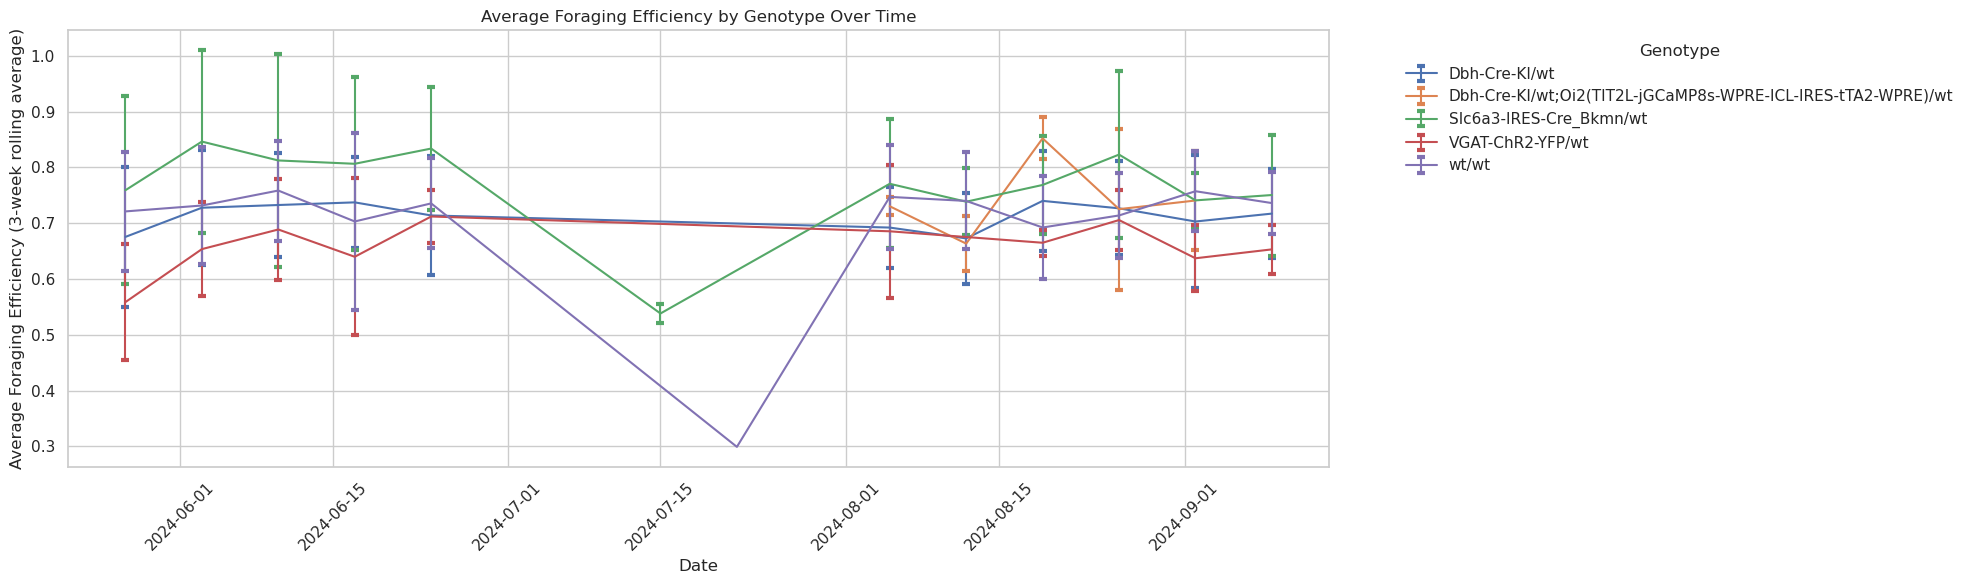

                                                    mean                      \
                                                   count      mean       std   
subject_genotype                                                               
Dbh-Cre-KI/wt                                       11.0  0.712673  0.023841   
Dbh-Cre-KI/wt;Oi2(TIT2L-jGCaMP8s-WPRE-ICL-IRES-...   5.0  0.742366  0.068362   
Slc6a3-IRES-Cre_Bkmn/wt                             12.0  0.765742  0.080715   
VGAT-ChR2-YFP/wt                                    10.0  0.659960  0.044206   
wt/wt                                               12.0  0.694689  0.126178   

                                                                        \
                                                         min       25%   
subject_genotype                                                         
Dbh-Cre-KI/wt                                       0.672821  0.697656   
Dbh-Cre-KI/wt;Oi2(TIT2L-jGCaMP8s-WPRE-ICL-IRES-...  0.663454  0

In [ ]:
# Making a cleaner plot / add std

geno_df['session_end_time'] = pd.to_datetime(geno_df['session_end_time'])

# Group by genotype and week
geno_df['week'] = geno_df['session_end_time'].dt.to_period('W')
grouped_df = geno_df.groupby(['subject_genotype', 'week'])['foraging_eff'].agg(['mean', 'std']).reset_index() # Calculate mean foraging efficiency 
grouped_df['week'] = grouped_df['week'].dt.to_timestamp()


# Take only top 5 most common genotypes in df
top_n_genotypes = geno_df['subject_genotype'].value_counts().nlargest(5).index
grouped_df = grouped_df[grouped_df['subject_genotype'].isin(top_n_genotypes)]


# Plot dataframe
plt.figure(figsize=(20, 6))
sns.set_style("whitegrid")

# Plot average foraging efficiency for each genotype 
for genotype in grouped_df['subject_genotype'].unique():
    data = grouped_df[grouped_df['subject_genotype'] == genotype]
    plt.errorbar(data['week'], data['mean'], yerr=data['std'], label=genotype, capsize=3, capthick=3)

plt.xlabel('Date')
plt.ylabel('Average Foraging Efficiency (3-week rolling average)')
plt.title('Average Foraging Efficiency by Genotype Over Time')
plt.xticks(rotation=45)
plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='best', frameon = False)

plt.tight_layout()
plt.show()

print(grouped_df.groupby('subject_genotype')[['mean', 'std']].describe())

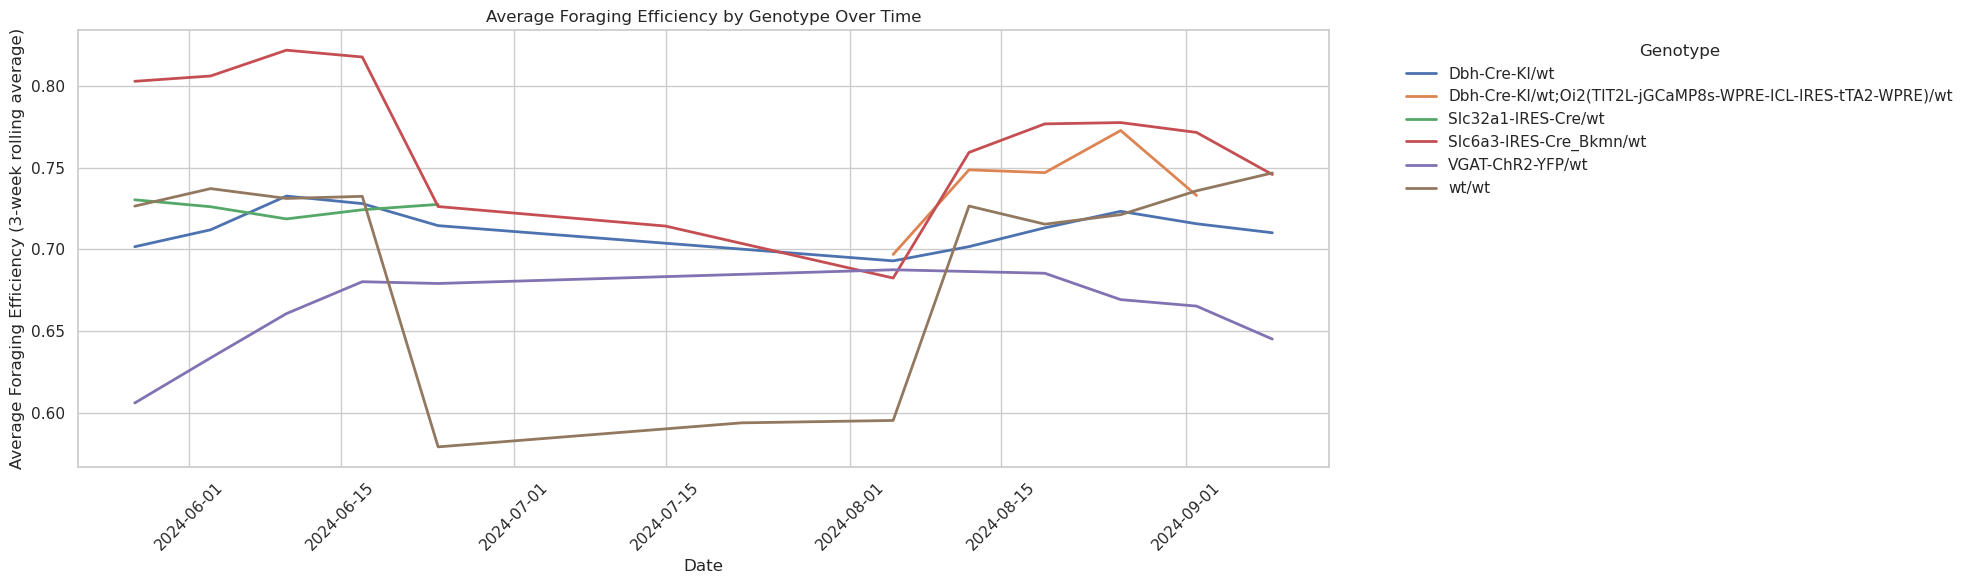

                                                    count      mean       std  \
subject_genotype                                                                
Dbh-Cre-KI/wt                                        11.0  0.713250  0.011785   
Dbh-Cre-KI/wt;Oi2(TIT2L-jGCaMP8s-WPRE-ICL-IRES-...    5.0  0.739620  0.027811   
Slc32a1-IRES-Cre/wt                                   5.0  0.725354  0.004367   
Slc6a3-IRES-Cre_Bkmn/wt                              12.0  0.766819  0.043362   
VGAT-ChR2-YFP/wt                                     10.0  0.661276  0.026026   
wt/wt                                                12.0  0.695131  0.064252   

                                                         min       25%  \
subject_genotype                                                         
Dbh-Cre-KI/wt                                       0.693000  0.705933   
Dbh-Cre-KI/wt;Oi2(TIT2L-jGCaMP8s-WPRE-ICL-IRES-...  0.696918  0.732980   
Slc32a1-IRES-Cre/wt                                 0.7

In [ ]:

grouped_df = geno_df.groupby(['subject_genotype', 'week'])['foraging_eff'].mean().reset_index()
grouped_df['week'] = grouped_df['week'].dt.to_timestamp()

# Use 3-week rolling average
grouped_df = grouped_df.sort_values(['subject_genotype', 'week'])
grouped_df['rolling_avg'] = grouped_df.groupby('subject_genotype')['foraging_eff'].rolling(window=3, center=True, min_periods=1).mean().reset_index(0, drop=True)


top_n_genotypes = geno_df['subject_genotype'].value_counts().nlargest(6).index
grouped_df = grouped_df[grouped_df['subject_genotype'].isin(top_n_genotypes)]


plt.figure(figsize=(20, 6))
sns.set_style("whitegrid")

sns.lineplot(data=grouped_df, x='week', y='rolling_avg', hue='subject_genotype', linewidth=2, errorbar='sd')

plt.xlabel('Date')
plt.ylabel('Average Foraging Efficiency (3-week rolling average)')
plt.title('Average Foraging Efficiency by Genotype Over Time')
plt.xticks(rotation=45)
plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False)

plt.tight_layout()
plt.show()

print(grouped_df.groupby('subject_genotype')['rolling_avg'].describe())